## Vibration analysis

This notebook mainly try to identify the vibration features on different condition, based on two sources of data, namely Vibrosight and PI System data

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
import time
from scipy.signal import butter, buttord, sosfreqz, sosfilt, sosfiltfilt, cheb2ord, cheby2, firwin, freqz, firls, lfilter, iirpeak, filtfilt
from scipy.fft import rfft, irfft, fftfreq

## Reconstruct the vibration data on different load condition

In [206]:
# load data from Vibrosight system
db_hl_vs = pd.read_excel("LGS1_VibrationOrbit_2023_HighLoad.xlsx", sheet_name="Orbit Comparison")
db_ll_vs = pd.read_excel("LGS1_VibrationOrbit_2023_LowLoad.xlsx", sheet_name="Orbit Comparison")

# load data from PI system
db_hl_pi = pd.read_excel("PI_HighLoad.xlsx", sheet_name="Sheet1")
db_ll_pi = pd.read_excel("PI_LowLoad.xlsx", sheet_name="Sheet1")

db_hl_pi['TimeStamp'] = pd.to_datetime(db_hl_pi['TimeStamp'])
db_ll_pi['TimeStamp'] = pd.to_datetime(db_ll_pi['TimeStamp'])

In [207]:
# defined function for ellipse reconstruction

def fit_ellipse(x, y):
    """

    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.


    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()


def cart_to_pol(coeffs):
    """

    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.

    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi


def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    """
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.

    """

    x0, y0, ap, bp, e, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y

### Analyze the low load condition on Turbine Guide bearing

In [129]:
# low load time frame limit
start_time = pd.to_datetime('2023-10-25 17:59:00')
end_time = pd.to_datetime('2023-10-25 18:01:00')

db_ll_pi = db_ll_pi[(db_ll_pi['TimeStamp']>=start_time) & (db_ll_pi['TimeStamp']<=end_time)]

data_pi = db_ll_pi
t_pi = data_pi['TimeStamp']
tgb_x_pi = data_pi['U-LGS1-TGB-X-PK-PK-270-AI']
tgb_y_pi = data_pi['U-LGS1-TGB-Y-PK-PK-340-AI']

In [116]:
data_vs = db_ll_vs
base_time = pd.Timestamp('2023-10-25 18:00:00')
data_vs['TGB – Time – Overall'] = data_vs['TGB – Time – Overall'].apply(lambda x: base_time + pd.Timedelta(seconds=x))

t_vs = data_vs['TGB – Time – Overall']
tgb_x_vs = data_vs['TGB – Disp – Overall – X']
tgb_y_vs = data_vs['TGB – Disp – Overall – Y']

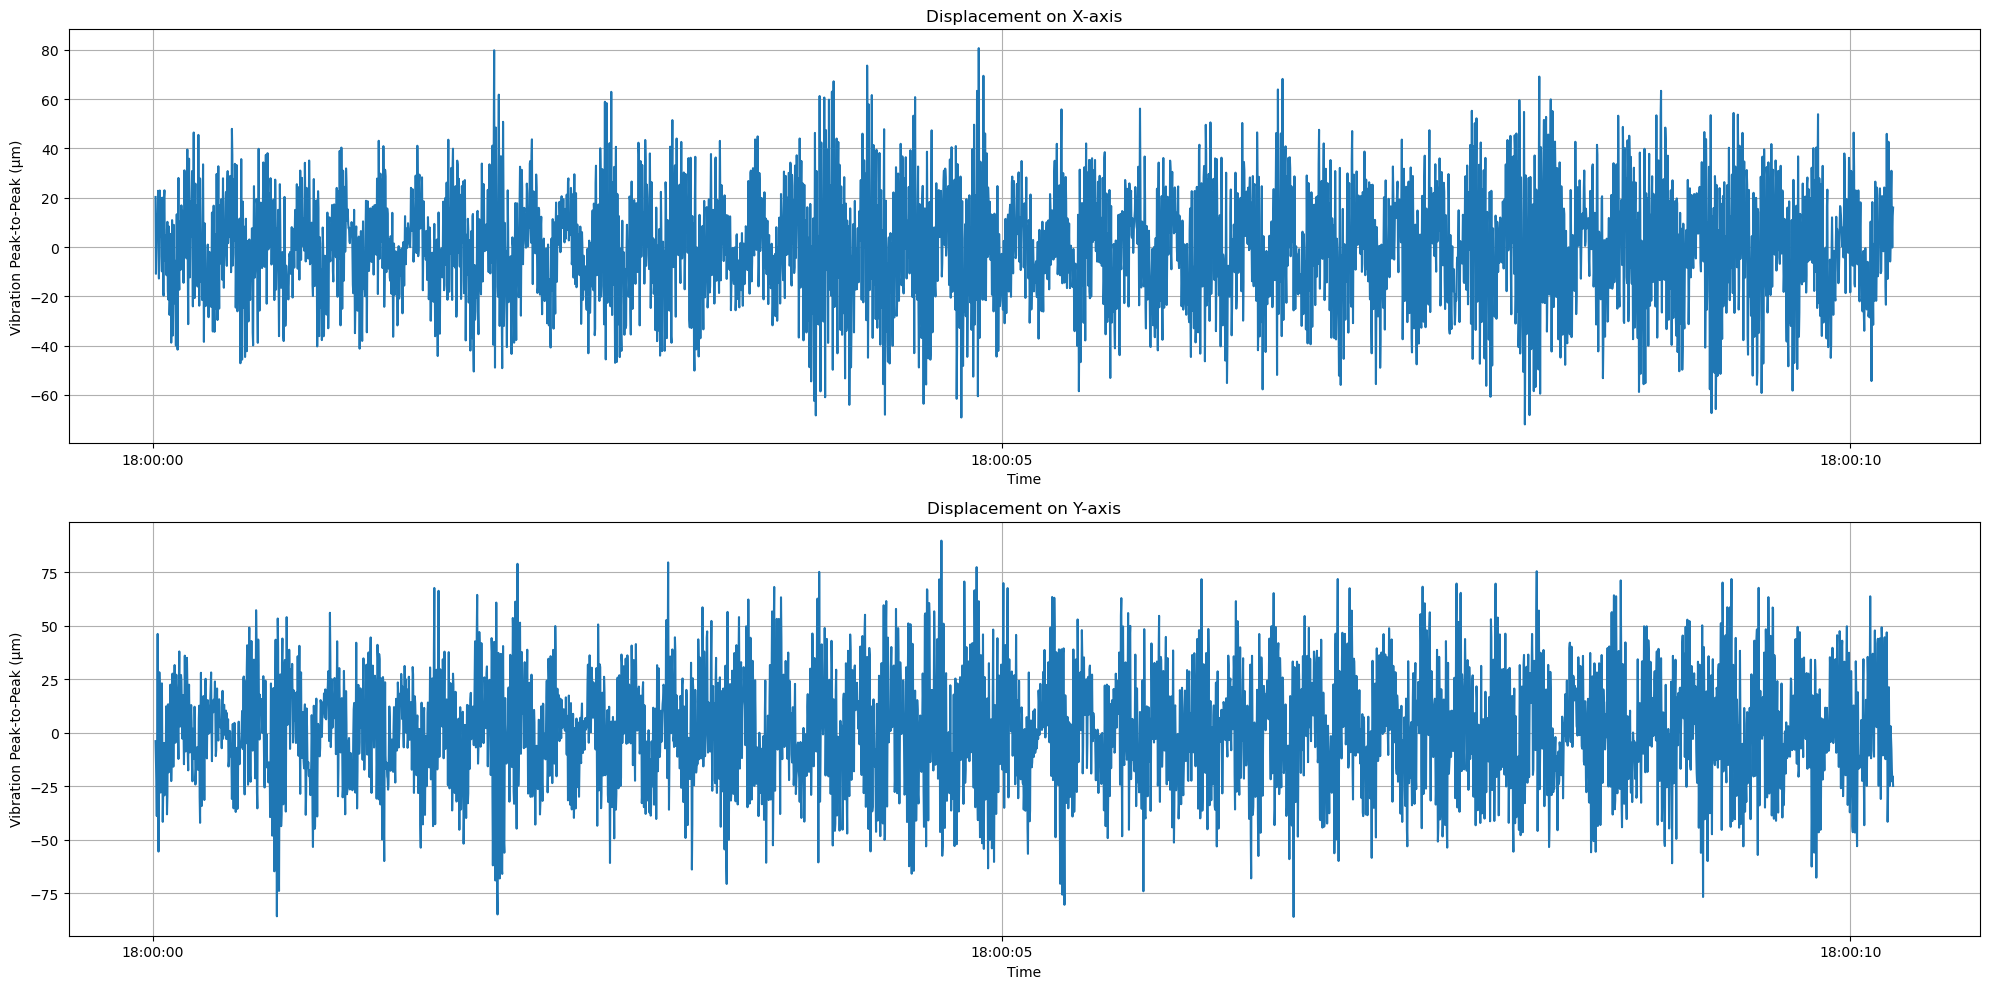

In [117]:
# plot the vibrosight data
import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%H:%M:%S')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(211)

ax.plot(t_vs, tgb_x_vs)
ax.xaxis.set_major_formatter(xformatter)
ax.grid()

ax.set_xlabel("Time")
ax.set_ylabel(u"Vibration Peak-to-Peak (\u03bcm)")
ax.set_title("Displacement on X-axis")

ay = fig.add_subplot(212)

ay.plot(t_vs, tgb_y_vs)
ay.xaxis.set_major_formatter(xformatter)
ay.grid()

ay.set_xlabel("Time")
ay.set_ylabel(u"Vibration Peak-to-Peak (\u03bcm)")
ay.set_title("Displacement on Y-axis")

fig.tight_layout()

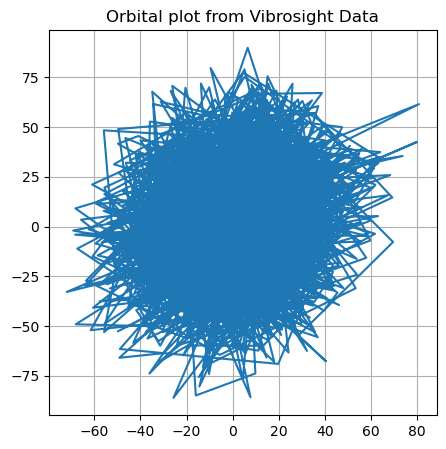

In [134]:
# plot orbital
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(tgb_x_vs, tgb_y_vs)
ax.set_title("Orbital plot from Vibrosight Data")
ax.grid()

In [118]:
# calculate the peak-to-peak of Vibrosigh data
t_pp = t_vs.iloc[-1]
x_pp = np.max(tgb_x_vs) - np.min(tgb_x_vs)
y_pp = np.max(tgb_y_vs) - np.min(tgb_y_vs)

print("Time peak-to-peak: " + str(t_pp))
print("X peak-to-peak: " + str(x_pp))
print("Y peak-to-peak: " + str(y_pp))

Time peak-to-peak: 2023-10-25 18:00:10.251780
X peak-to-peak: 152.67457000000002
Y peak-to-peak: 175.85568


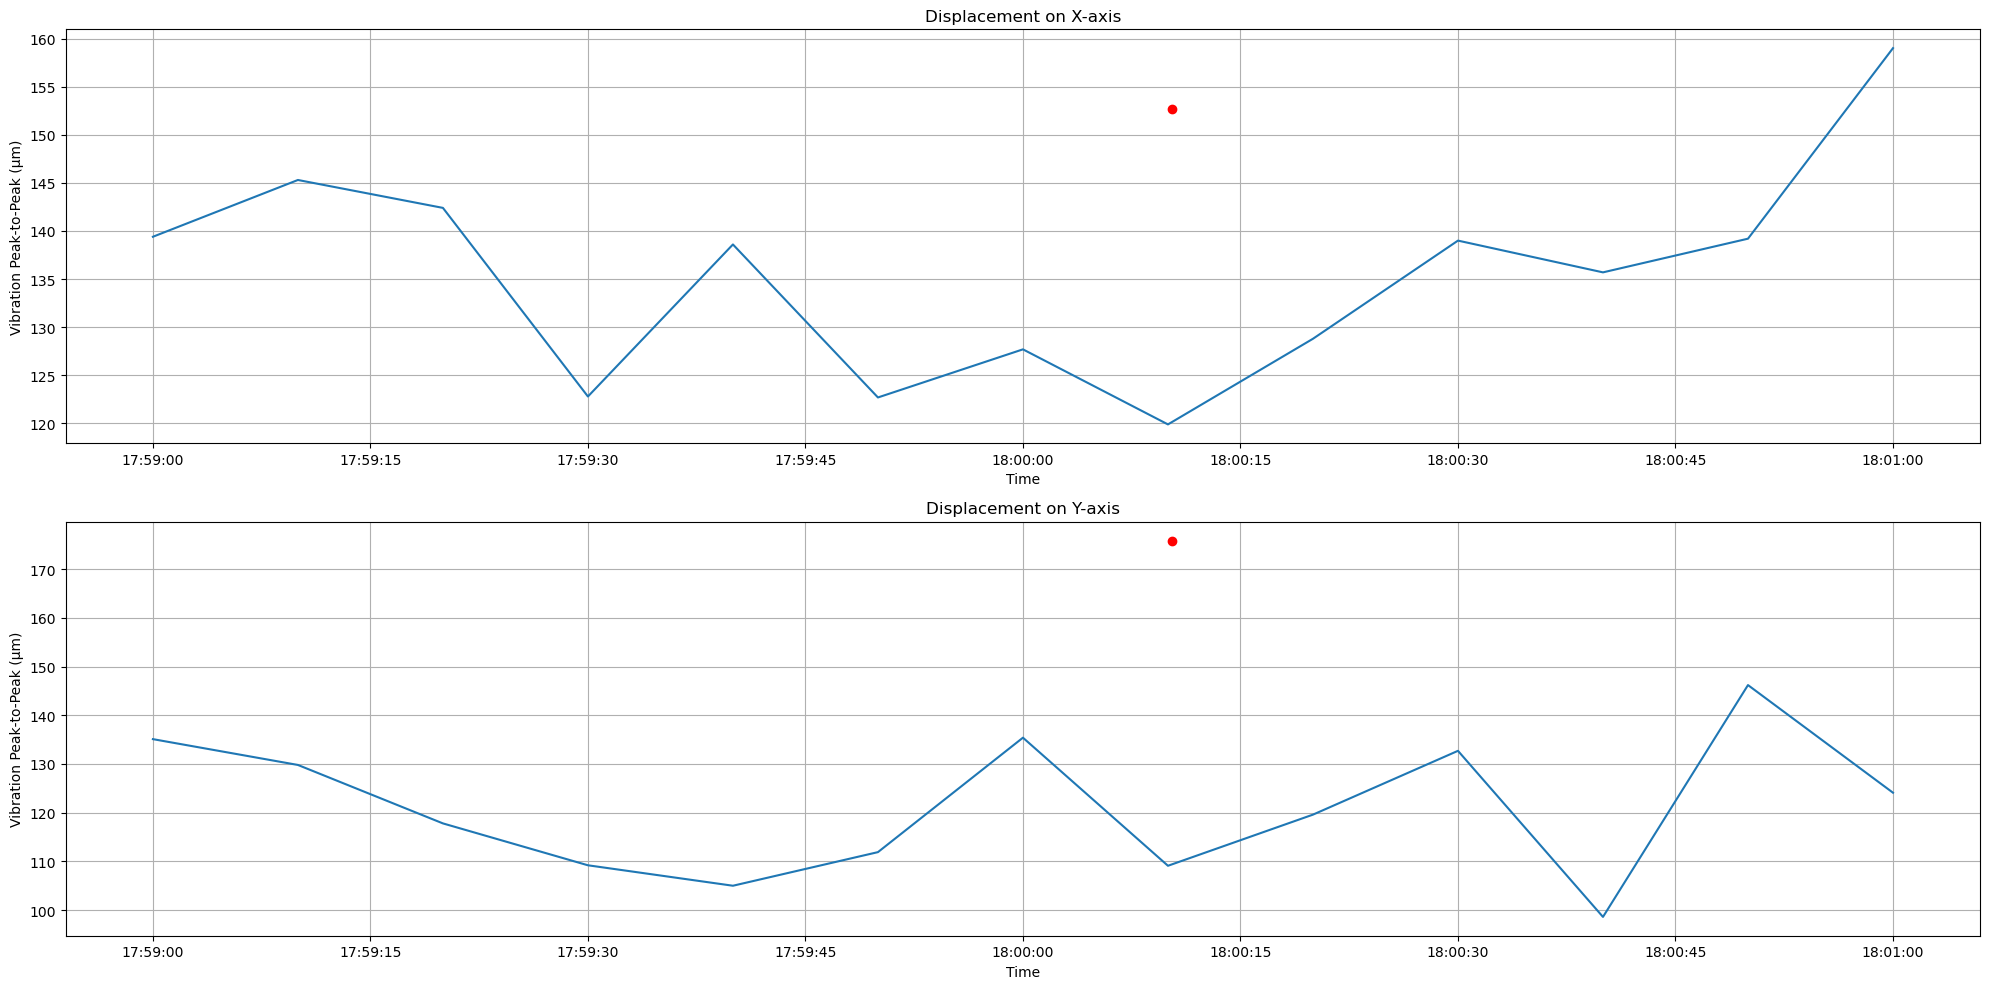

In [142]:
# plot time series data 
xformatter = mdates.DateFormatter('%H:%M:%S')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(211)

ax.plot(t_pi, tgb_x_pi)
ax.plot(t_pp, x_pp, 'o', color='red')
ax.xaxis.set_major_formatter(xformatter)
ax.grid()

ax.set_xlabel("Time")
ax.set_ylabel(u"Vibration Peak-to-Peak (\u03bcm)")
ax.set_title("Displacement on X-axis")

ay = fig.add_subplot(212)

ay.plot(t_pi, tgb_y_pi)
ay.plot(t_pp, y_pp, 'o', color='red')
ay.xaxis.set_major_formatter(xformatter)
ay.grid()

ay.set_xlabel("Time")
ay.set_ylabel(u"Vibration Peak-to-Peak (\u03bcm)")
ay.set_title("Displacement on Y-axis")

fig.tight_layout()

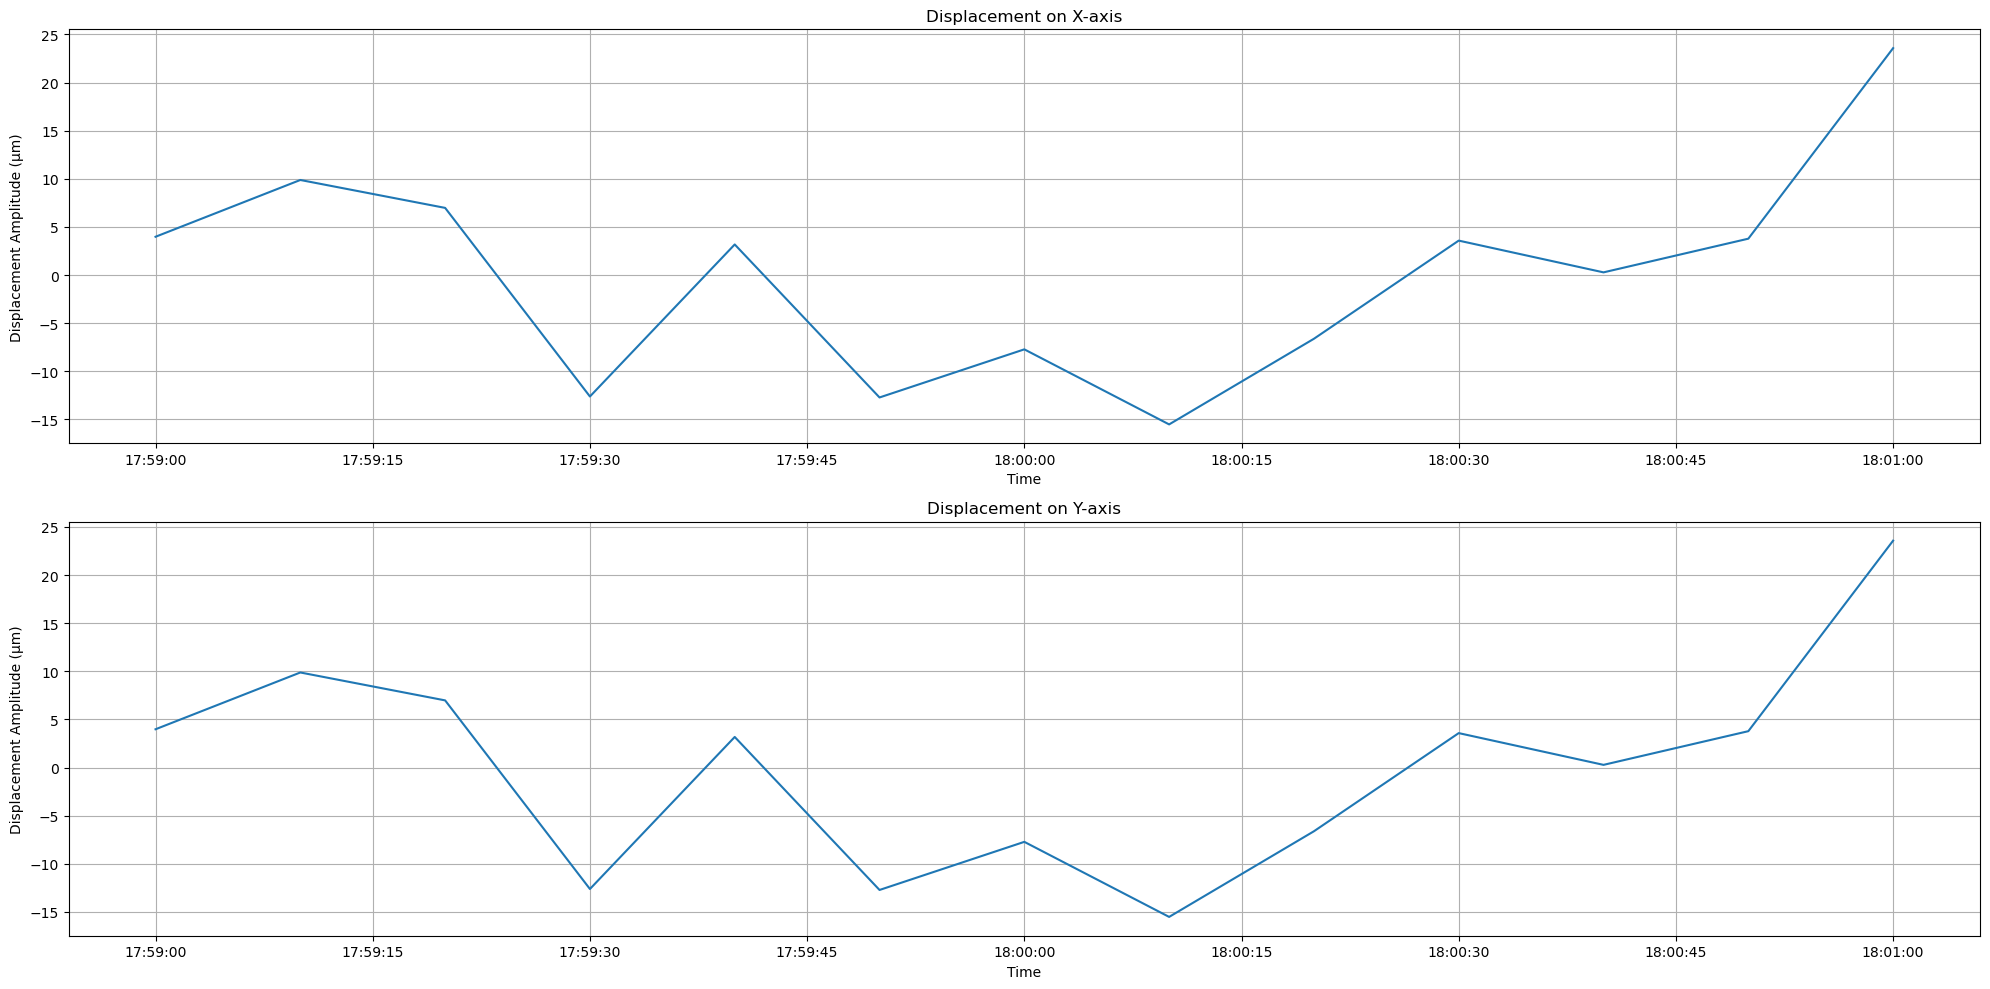

In [141]:
# convert to peak vibnation and remove dc signals 
import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%H:%M:%S')

tgb_x_pi_compensated = tgb_x_pi - np.mean(tgb_x_pi)
tgb_y_pi_compensated = tgb_y_pi - np.mean(tgb_y_pi) 

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(211)

ax.plot(t_pi, tgb_x_pi_compensated)
ax.xaxis.set_major_formatter(xformatter)
ax.grid()

ax.set_xlabel("Time")
ax.set_ylabel(u"Displacement Amplitude (\u03bcm)")
ax.set_title("Displacement on X-axis")

ay = fig.add_subplot(212)

ay.plot(t_pi, tgb_x_pi_compensated)
ay.xaxis.set_major_formatter(xformatter)
ay.grid()

ay.set_xlabel("Time")
ay.set_ylabel(u"Displacement Amplitude (\u03bcm)")
ay.set_title("Displacement on Y-axis")

fig.tight_layout()

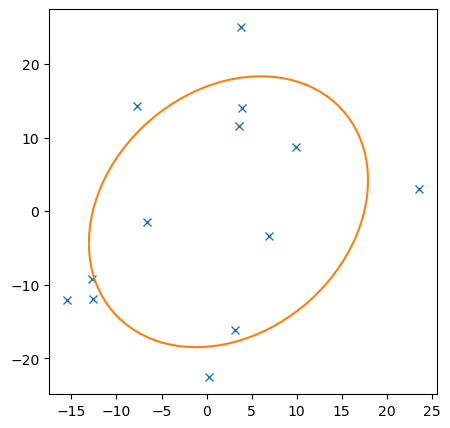

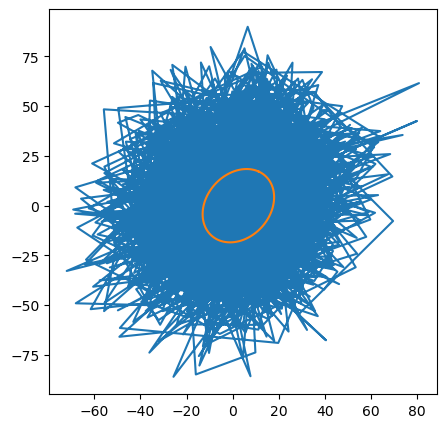

In [143]:
# fit the orbital plot
coeffs = fit_ellipse(tgb_x_pi_compensated, tgb_y_pi_compensated)
x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.plot(tgb_x_pi_compensated, tgb_y_pi_compensated, 'x')
ax.plot(x, y)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
# ax.plot(data_vs['TGB – Disp – 1X – X'], data_vs['TGB – Disp – 1X – Y'])
ax.plot(tgb_x_vs, tgb_y_vs)
ax.plot(x, y)

### Analyze the low load condition on Upper Guide bearing

In [219]:
# low load time frame limit
start_time = pd.to_datetime('2023-10-08 00:59:40')
end_time = pd.to_datetime('2023-10-08 01:00:20')

db_hl_pi = db_hl_pi[(db_hl_pi['TimeStamp']>=start_time) & (db_hl_pi['TimeStamp']<=end_time)]

data_pi = db_hl_pi
t_pi = data_pi['TimeStamp']
tgb_x_pi = data_pi['U-LGS1-UGB-X-PK-PK-70-AI']
tgb_y_pi = data_pi['U-LGS1-UGB-Y-PK-PK-340-AI']
tgb_rpm = data_pi['U-LGS1-SI-81101-AI']
rpm = tgb_rpm.mean() / 60

In [303]:
data_vs = db_hl_vs
base_time = pd.Timestamp('2023-10-08 01:00:00')
data_vs['UGB – Time – 1X'] = data_vs['UGB – Time – 1X'].apply(lambda x: base_time + pd.Timedelta(seconds=x))

t_vs = data_vs['UGB – Time – 1X']
tgb_x_vs = data_vs['UGB – Disp – 1X – X']
tgb_y_vs = data_vs['UGB – Disp – 1X – Y']

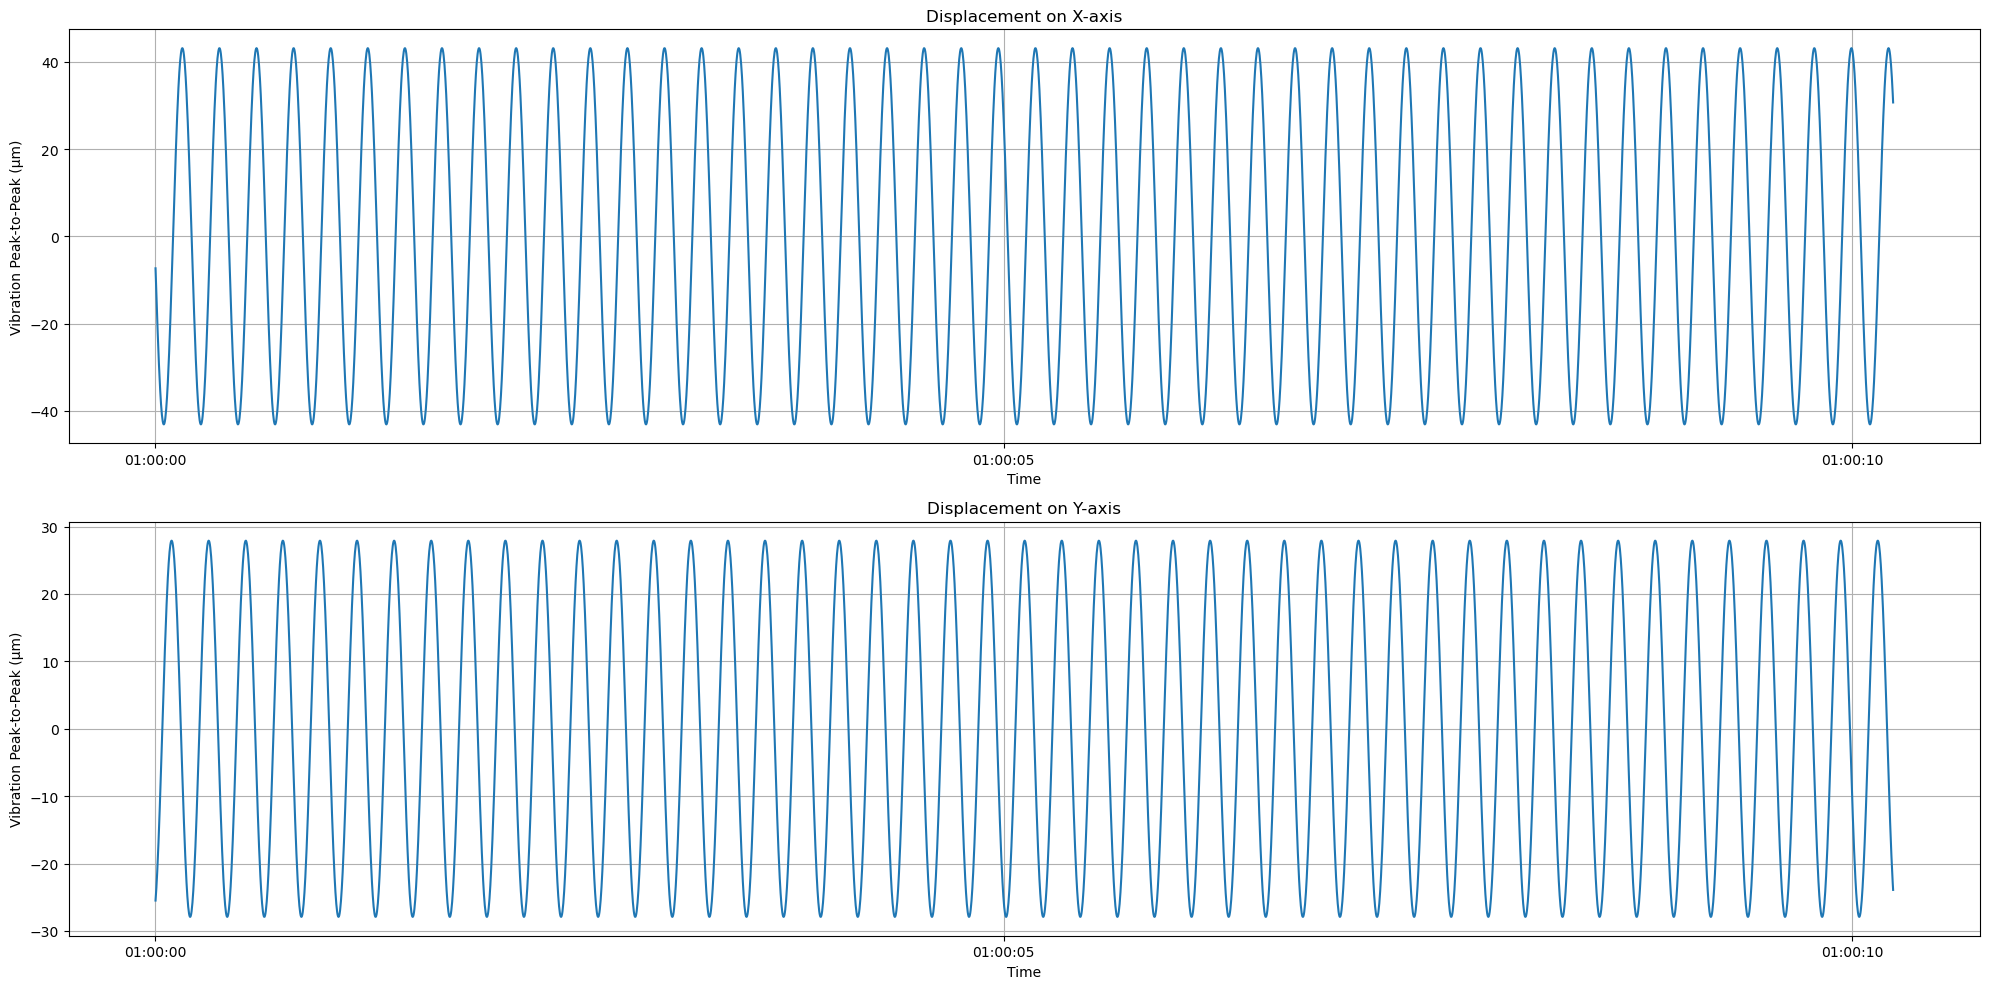

In [304]:
# plot the vibrosight data
import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%H:%M:%S')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(211)

ax.plot(t_vs, tgb_x_vs)
ax.xaxis.set_major_formatter(xformatter)
ax.grid()

ax.set_xlabel("Time")
ax.set_ylabel(u"Vibration Peak-to-Peak (\u03bcm)")
ax.set_title("Displacement on X-axis")

ay = fig.add_subplot(212)

ay.plot(t_vs, tgb_y_vs)
ay.xaxis.set_major_formatter(xformatter)
ay.grid()

ay.set_xlabel("Time")
ay.set_ylabel(u"Vibration Peak-to-Peak (\u03bcm)")
ay.set_title("Displacement on Y-axis")

fig.tight_layout()

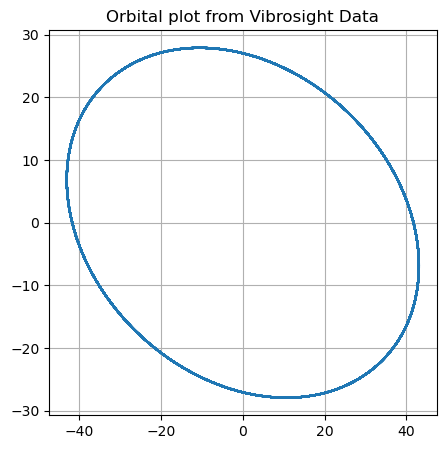

In [305]:
# plot orbital
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(tgb_x_vs, tgb_y_vs)
ax.set_title("Orbital plot from Vibrosight Data")
ax.grid()

In [217]:
# calculate the peak-to-peak of Vibrosigh data
t_pp = t_vs.iloc[-1]
x_pp = np.max(tgb_x_vs) - np.min(tgb_x_vs)
y_pp = np.max(tgb_y_vs) - np.min(tgb_y_vs)

print("Time peak-to-peak: " + str(t_pp))
print("X peak-to-peak: " + str(x_pp))
print("Y peak-to-peak: " + str(y_pp))

Time peak-to-peak: 2023-10-08 01:00:10.263780
X peak-to-peak: 111.56825
Y peak-to-peak: 82.42330000000001


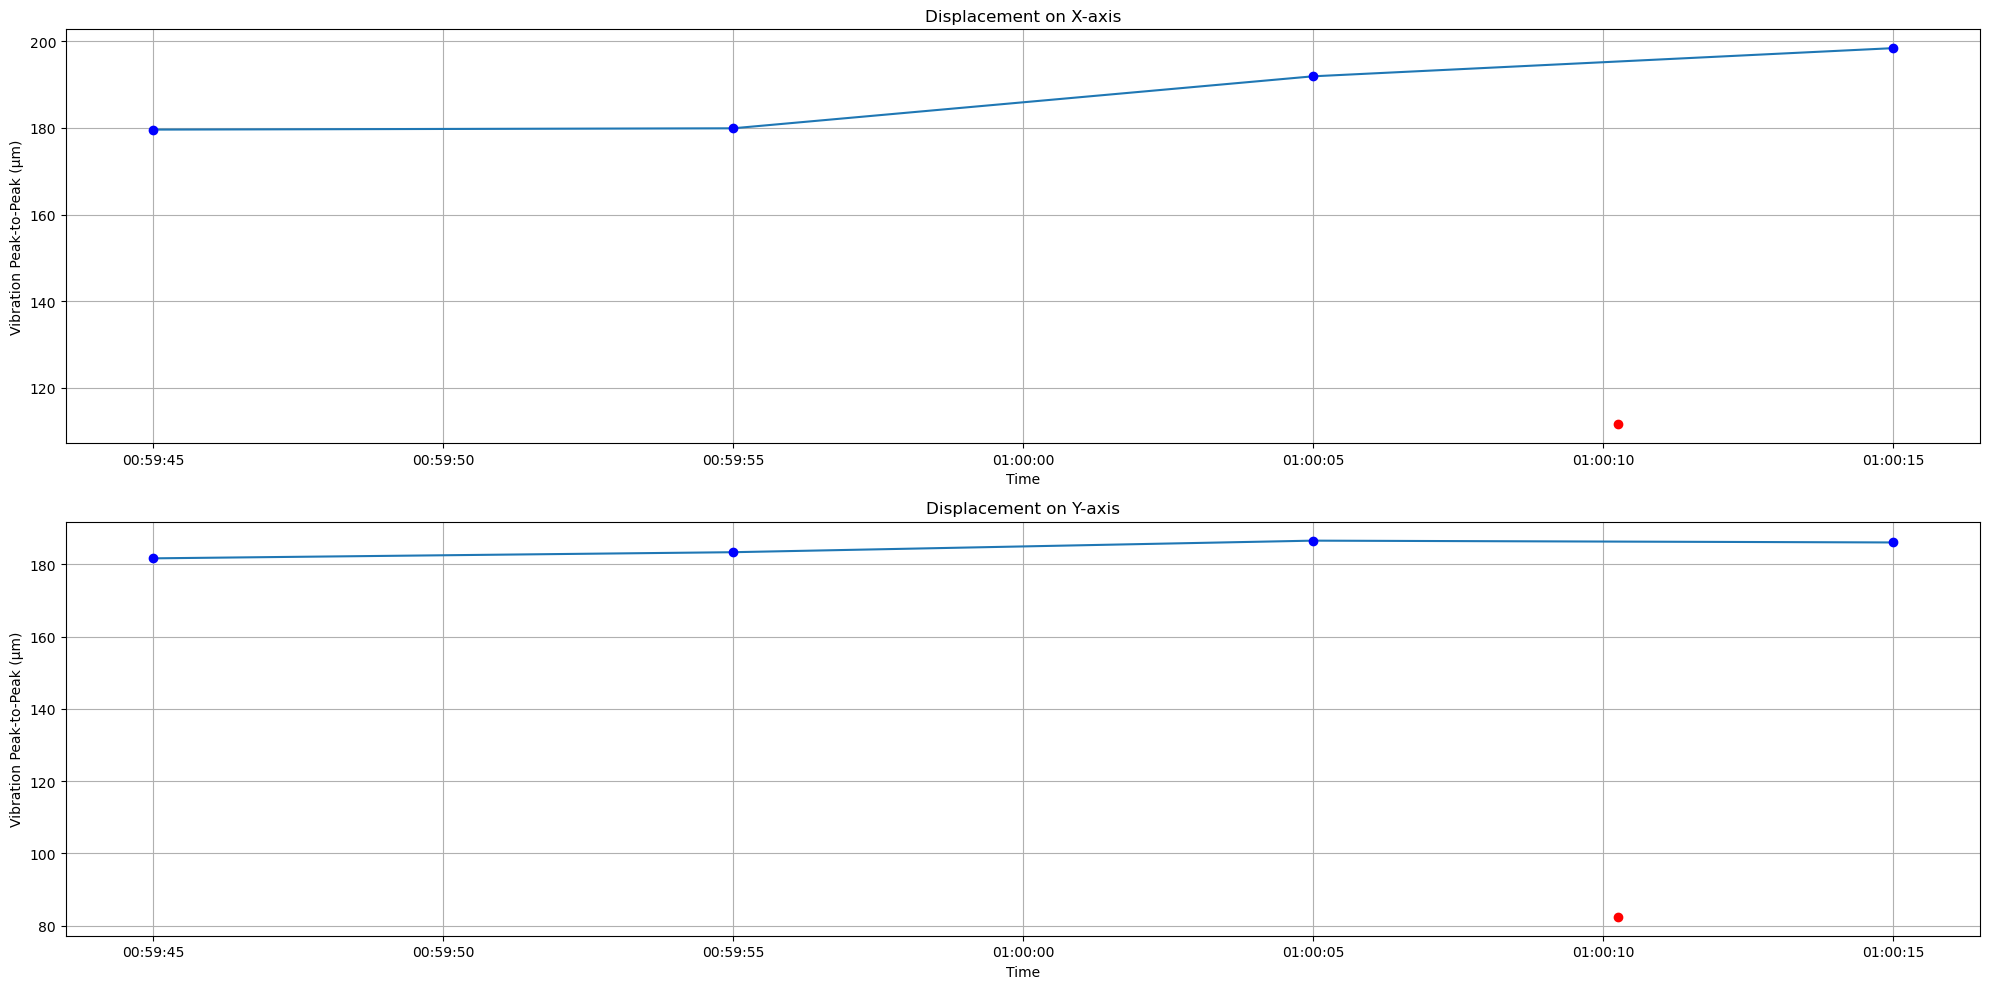

In [223]:
# plot time series data 
xformatter = mdates.DateFormatter('%H:%M:%S')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(211)

ax.plot(t_pi, tgb_x_pi)
ax.plot(t_pi, tgb_x_pi, 'o', color='blue')
ax.plot(t_pp, x_pp, 'o', color='red')
ax.xaxis.set_major_formatter(xformatter)
ax.grid()

ax.set_xlabel("Time")
ax.set_ylabel(u"Vibration Peak-to-Peak (\u03bcm)")
ax.set_title("Displacement on X-axis")

ay = fig.add_subplot(212)

ay.plot(t_pi, tgb_y_pi)
ay.plot(t_pi, tgb_y_pi, 'o', color='blue')
ay.plot(t_pp, y_pp, 'o', color='red')
ay.xaxis.set_major_formatter(xformatter)
ay.grid()

ay.set_xlabel("Time")
ay.set_ylabel(u"Vibration Peak-to-Peak (\u03bcm)")
ay.set_title("Displacement on Y-axis")

fig.tight_layout()

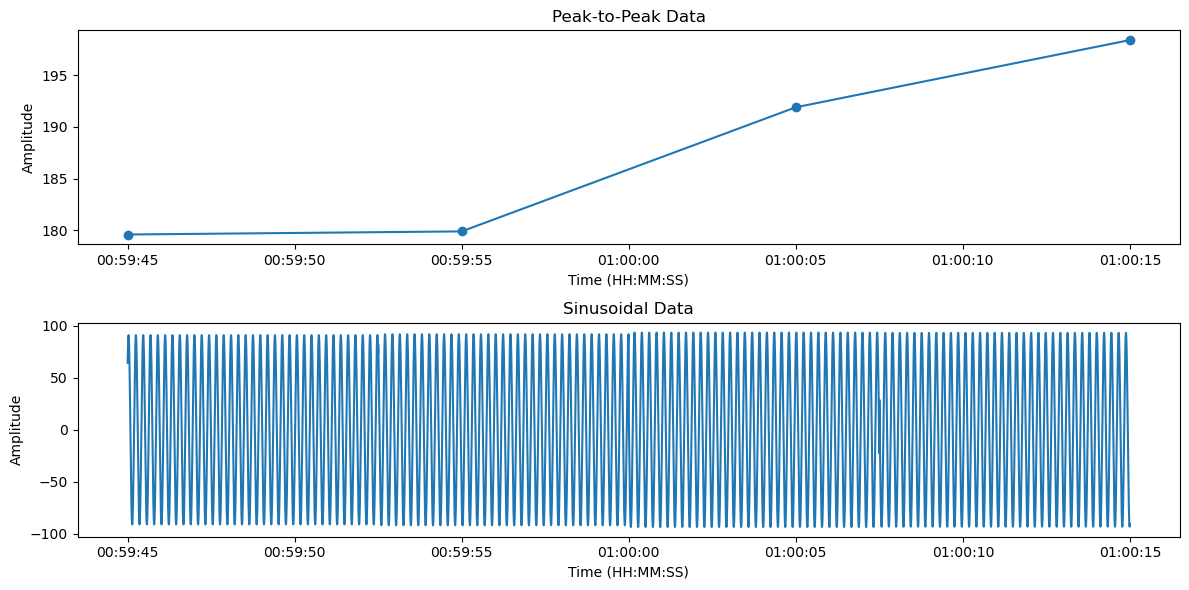

In [296]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

def peak_to_sinusoid(start_time, end_time, sampling_frequency, peak_to_peak_data, time_varying_frequency, phase_shift_degrees):
    phase_shift_radians = np.deg2rad(phase_shift_degrees)  # Convert phase shift to radians
    num_samples = int((end_time - start_time).total_seconds() * sampling_frequency)
    num_segments = len(peak_to_peak_data)
    segment_duration = (end_time - start_time) / num_segments
    time_delta = timedelta(seconds=1 / sampling_frequency)
    
    time = []
    sinusoid_data = []
    current_time = start_time
    current_phase = 0  # Initial phase

    for segment in range(num_segments):
        amplitude = peak_to_peak_data[segment] / 2
        frequency = time_varying_frequency[segment]
        segment_end_time = current_time + segment_duration
        
        while current_time < segment_end_time:
            time.append(current_time)
            # Add phase shift to the sine function
            sinusoid_data.append(amplitude * np.sin(2 * np.pi * frequency * (current_time - start_time).total_seconds() + current_phase + phase_shift_radians))
            current_time += time_delta

        # Update phase for continuity
        current_phase += 2 * np.pi * frequency * segment_duration.total_seconds()
    
    return time, sinusoid_data

# Example usage:
start_time = datetime.strptime('2023-10-08 00:59:45', '%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime('2023-10-08 01:00:15', '%Y-%m-%d %H:%M:%S')
sampling_frequency = 400  # Sampling frequency in Hz

# Generate random peak-to-peak data and frequency arrays
peak_to_peak_data = tgb_x_pi.to_numpy()  # Random peak-to-peak values
time_varying_frequency = tgb_rpm.to_numpy() / 60 # Random frequencies
num_segments = len(tgb_x_pi)

# Define phase shift
phase_shift_degrees = 0

time, x_sinusoid_data = peak_to_sinusoid(start_time, end_time, sampling_frequency, peak_to_peak_data, time_varying_frequency, phase_shift_degrees)

# Plot peak-to-peak data
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
times = np.linspace(start_time.timestamp(), end_time.timestamp(), num_segments)
times = [datetime.fromtimestamp(t) for t in times]
plt.plot(times, peak_to_peak_data, marker='o')
plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('Amplitude')
plt.title('Peak-to-Peak Data')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Plot sinusoidal data
plt.subplot(2, 1, 2)
plt.plot(time, sinusoid_data)
plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('Amplitude')
plt.title('Sinusoidal Data')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()


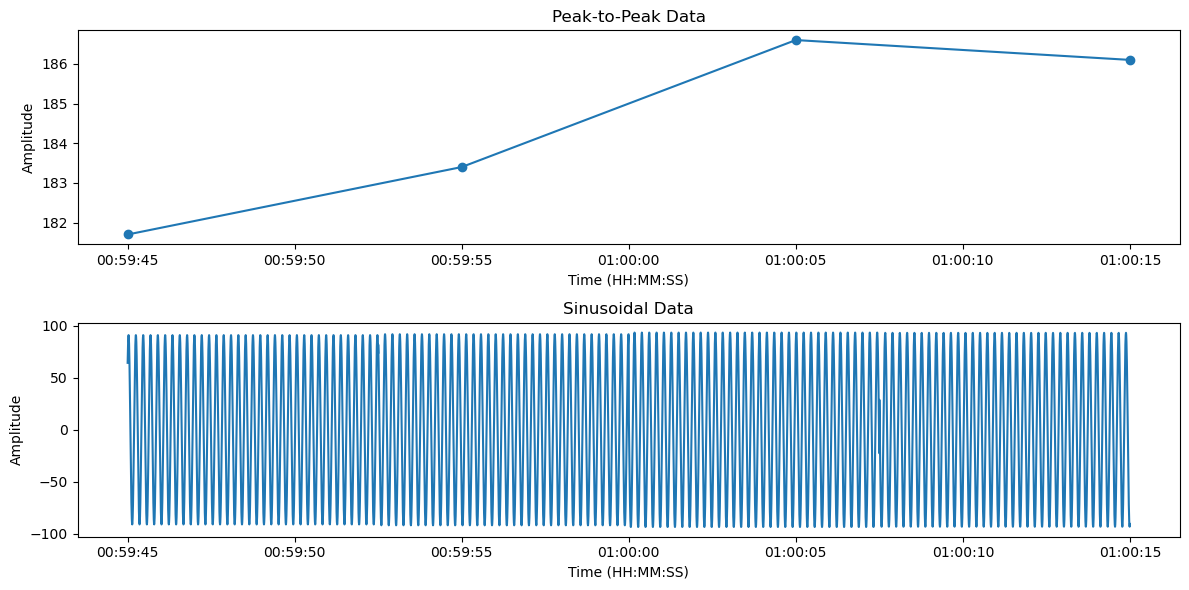

In [297]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

def peak_to_sinusoid(start_time, end_time, sampling_frequency, peak_to_peak_data, time_varying_frequency, phase_shift_degrees):
    phase_shift_radians = np.deg2rad(phase_shift_degrees)  # Convert phase shift to radians
    num_samples = int((end_time - start_time).total_seconds() * sampling_frequency)
    num_segments = len(peak_to_peak_data)
    segment_duration = (end_time - start_time) / num_segments
    time_delta = timedelta(seconds=1 / sampling_frequency)
    
    time = []
    sinusoid_data = []
    current_time = start_time
    current_phase = 0  # Initial phase

    for segment in range(num_segments):
        amplitude = peak_to_peak_data[segment] / 2
        frequency = time_varying_frequency[segment]
        segment_end_time = current_time + segment_duration
        
        while current_time < segment_end_time:
            time.append(current_time)
            # Add phase shift to the sine function
            sinusoid_data.append(amplitude * np.cos(2 * np.pi * frequency * (current_time - start_time).total_seconds() + current_phase + phase_shift_radians))
            current_time += time_delta

        # Update phase for continuity
        current_phase += 2 * np.pi * frequency * segment_duration.total_seconds()
    
    return time, sinusoid_data

# Example usage:
start_time = datetime.strptime('2023-10-08 00:59:45', '%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime('2023-10-08 01:00:15', '%Y-%m-%d %H:%M:%S')
sampling_frequency = 400  # Sampling frequency in Hz

# Generate random peak-to-peak data and frequency arrays
peak_to_peak_data = tgb_y_pi.to_numpy()  # Random peak-to-peak values
time_varying_frequency = tgb_rpm.to_numpy() / 60 # Random frequencies
num_segments = len(tgb_y_pi)

# Define phase shift
phase_shift_degrees = 0

time, y_sinusoid_data = peak_to_sinusoid(start_time, end_time, sampling_frequency, peak_to_peak_data, time_varying_frequency, phase_shift_degrees)

# Plot peak-to-peak data
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
times = np.linspace(start_time.timestamp(), end_time.timestamp(), num_segments)
times = [datetime.fromtimestamp(t) for t in times]
plt.plot(times, peak_to_peak_data, marker='o')
plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('Amplitude')
plt.title('Peak-to-Peak Data')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Plot sinusoidal data
plt.subplot(2, 1, 2)
plt.plot(time, sinusoid_data)
plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('Amplitude')
plt.title('Sinusoidal Data')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()


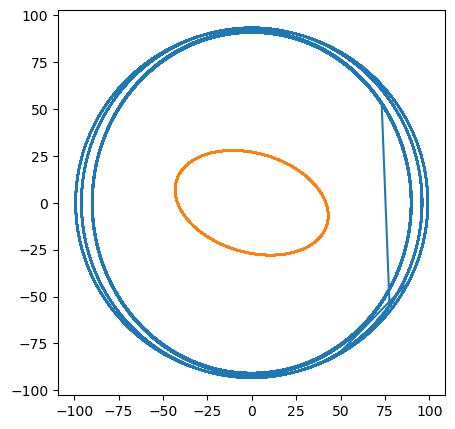

In [302]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.plot(x_sinusoid_data, y_sinusoid_data)
ax.plot(data_vs['UGB – Disp – 1X – X'], data_vs['UGB – Disp – 1X – Y'])
# ax.plot(tgb_x_vs, tgb_y_vs)


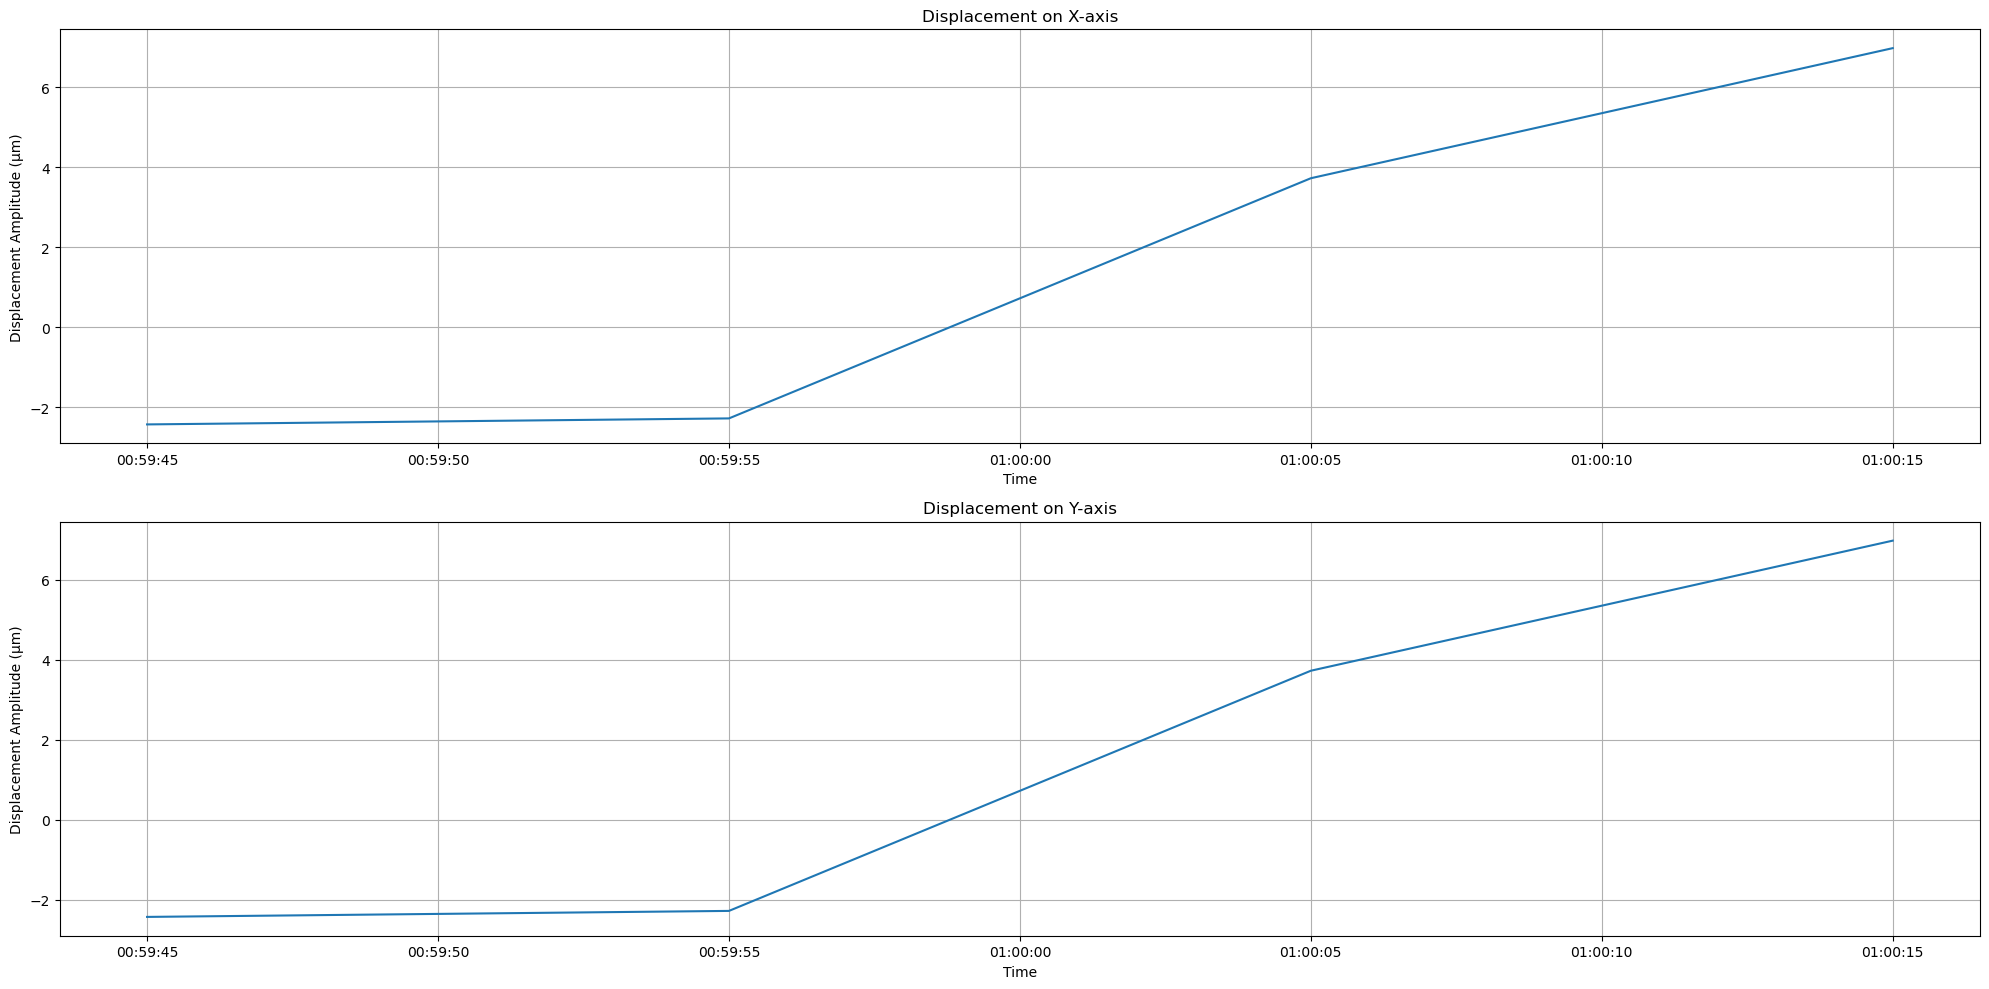

In [306]:
# convert to peak vibnation and remove dc signals 
import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%H:%M:%S')

tgb_x_pi_compensated = tgb_x_pi/2 - np.mean(tgb_y_pi/2)
tgb_y_pi_compensated = tgb_y_pi/2 - np.mean(tgb_y_pi/2)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(211)

ax.plot(t_pi, tgb_x_pi_compensated)
ax.xaxis.set_major_formatter(xformatter)
ax.grid()

ax.set_xlabel("Time")
ax.set_ylabel(u"Displacement Amplitude (\u03bcm)")
ax.set_title("Displacement on X-axis")

ay = fig.add_subplot(212)

ay.plot(t_pi, tgb_x_pi_compensated)
ay.xaxis.set_major_formatter(xformatter)
ay.grid()

ay.set_xlabel("Time")
ay.set_ylabel(u"Displacement Amplitude (\u03bcm)")
ay.set_title("Displacement on Y-axis")

fig.tight_layout()

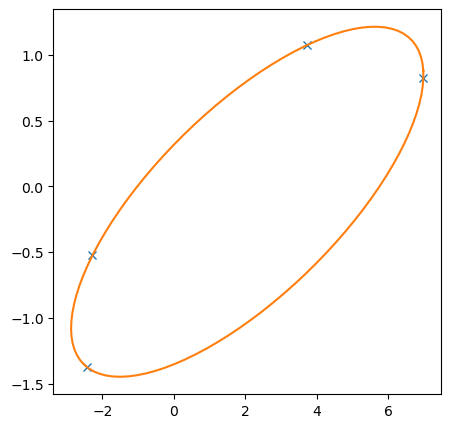

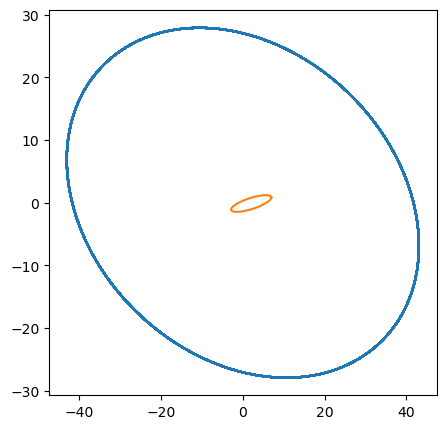

In [307]:
# fit the orbital plot
coeffs = fit_ellipse(tgb_x_pi_compensated, tgb_y_pi_compensated)
x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.plot(tgb_x_pi_compensated, tgb_y_pi_compensated, 'x')
ax.plot(x, y)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
# ax.plot(data_vs['UGB – Disp – 1X – X'], data_vs['UGB – Disp – 1X – Y'])
ax.plot(tgb_x_vs, tgb_y_vs)
ax.plot(x, y)